In [1]:
import os
import sys
import delta
from pyspark.sql.window import Window
import pyspark.sql.functions as psf
import pandas as pd
import pyspark.sql
from pyspark.sql.types import StructType, StructField, DateType, \
    StringType, DoubleType, TimestampType
import matplotlib.pyplot as plt

# sys.path.insert(0, os.path.abspath('./source/Producto_DIA_DP'))

from SparkDBUtils import SparkDB
sparkdb = SparkDB()
spark = sparkdb.spark

In [4]:
spark.sql("show schemas").show(truncate=False)

+----------------+
|namespace       |
+----------------+
|analisis_precios|
|default         |
|producto_dia    |
+----------------+



In [27]:
spark.sql("show tables in producto_dia").show(truncate=False)

+------------+---------------------+-----------+
|namespace   |tableName            |isTemporary|
+------------+---------------------+-----------+
|producto_dia|producto_dim         |false      |
|producto_dia|producto_dim_20230914|false      |
|producto_dia|sequences_cfg        |false      |
|producto_dia|staging_product      |false      |
+------------+---------------------+-----------+



In [2]:
df = spark.table("producto_dia.staging_product").toPandas()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id_producto  0 non-null      object
 1   url_product  0 non-null      object
 2   index        0 non-null      int32 
dtypes: int32(1), object(2)
memory usage: 0.0+ bytes


In [18]:
df_producto_dim = spark.table("producto_dia.producto_dim")

dfp_producto_dim = df_producto_dim.toPandas()

dfp_producto_dim.info()

c:\users\carlos\proyectos\foodecommercescraper\venv\lib\site-packages\pyspark\sql\pandas\conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16968 entries, 0 to 16967
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   product_id  16968 non-null  object        
 1   product     15416 non-null  object        
 2   brand       15416 non-null  object        
 3   categories  16968 non-null  object        
 4   units       16029 non-null  object        
 5   price       16029 non-null  float64       
 6   unit_price  16029 non-null  float64       
 7   discount    0 non-null      float64       
 8   date        16968 non-null  object        
 9   ts_load     16968 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), object(6)
memory usage: 1.3+ MB


In [20]:
dfp_producto_dim.head()

,product_id,product,brand,categories,units,price,unit_price,discount,date,ts_load
0,223231,Queso fresco sin lactosa,Dia,"[Charcutería y quesos, Quesos fresco]",€/KILO),1.68,6.72,NaN,2023-09-12,2023-09-12 06:29:40.991637
1,224474,Ensalada mezclum,Vegecampo,"[Verduras, Verduras y ensaladas preparadas]",€/KILO),0.95,6.33,NaN,2023-09-12,2023-09-12 06:29:41.358288
2,225399,Mini barritas de chocolate con caramelo y caca...,Snickers,"[Azúcar. chocolates y caramelos, Chocolates y ...",€/KILO),2.29,15.90,NaN,2023-09-12,2023-09-12 06:29:41.619678
3,225767,Tinte casta,Nutrisse,"[Perfumería. higiene. salud, Tintes]",€/UNIDAD),5.89,5.89,NaN,2023-09-12,2023-09-12 06:29:41.847959
4,226508,Pizza serrana,Al,"[Pizzas y platos preparados, Pizzas]",€/KILO),2.69,6.90,NaN,2023-09-12,2023-09-12 06:29:42.122930


Obtenemos los productos duplicados

In [21]:
duplicates = dfp_producto_dim.groupby("product_id")["product_id"]\
    .count()\
    .loc[lambda x : x >= 2]\
    .index

dfp_producto_dim[dfp_producto_dim.product_id.isin(duplicates)].sort_values(by="product_id")


,product_id,product,brand,categories,units,price,unit_price,discount,date,ts_load
13323,100,Aceite de oliva suave,Carbonell,"[Aceites. salsas y especias, Aceites]",€/LITRO),10.29,10.29,NaN,2023-09-12,2023-09-12 06:59:42.270201
9829,100,Aceite de oliva suave,Carbonell,"[Aceites. salsas y especias, Aceites]",€/LITRO),10.29,10.29,NaN,2023-09-13,2023-09-13 08:15:19.966818
12196,1000,Salsa cocktail,Ybarra,"[Aceites. salsas y especias, Mayonesa y otras ...",€/LITRO),1.55,6.89,NaN,2023-09-13,2023-09-13 08:08:12.868690
13955,1000,Salsa cocktail,Ybarra,"[Aceites. salsas y especias, Mayonesa y otras ...",€/LITRO),1.55,6.89,NaN,2023-09-12,2023-09-12 07:06:06.930044
12604,100267,Galletas rellenas de chocolate estrellas,Lu,"[Galletas. bollos y cereales, Galletas]",€/KILO),2.31,10.27,NaN,2023-09-13,2023-09-13 07:53:02.324466
...,...,...,...,...,...,...,...,...,...,...
9095,99217,Desodorante roll,Dove,"[Perfumería. higiene. salud, Desodorantes]",€/100 ML.),2.29,4.58,NaN,2023-09-12,2023-09-12 06:37:57.820138
4982,99265,Agua mineral con gas,Dia,"[Agua. refrescos y zumos, Agua]",€/LITRO),0.38,0.25,NaN,2023-09-12,2023-09-12 06:50:44.534846
6985,99265,Agua mineral con gas,Dia,"[Agua. refrescos y zumos, Agua]",€/LITRO),0.38,0.25,NaN,2023-09-13,2023-09-13 08:03:16.679983
7682,99783,Chocolate con leche relleno con caramelo y ave...,Milka,"[Azúcar. chocolates y caramelos, Chocolates y ...",€/KILO),3.41,11.37,NaN,2023-09-13,2023-09-13 07:47:33.358275


<AxesSubplot: >

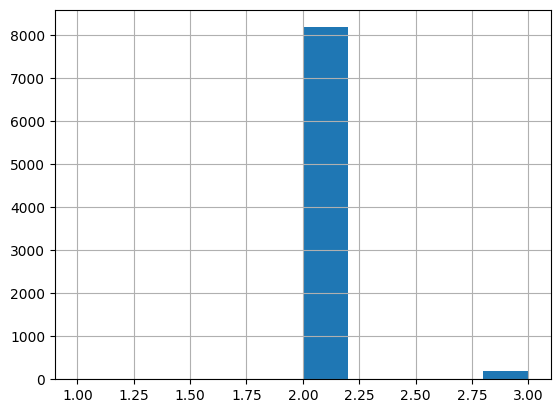

In [22]:
dfp_producto_dim.groupby("product_id")["product_id"].count().hist()

# Backup tabla productos

In [26]:
df_producto_dim.write.format("delta").saveAsTable("producto_dia.producto_dim_20230914", mode="overwrite")

# DELETE producto_dia.staging_product

In [4]:
dt = delta.DeltaTable.forName(spark, "producto_dia.staging_product")

In [5]:
dt.delete(psf.column("index") > "112")

In [8]:
dt.toDF().toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id_producto  113 non-null    object
 1   url_product  113 non-null    object
 2   index        113 non-null    int32 
dtypes: int32(1), object(2)
memory usage: 2.3+ KB


# DELETE producto_dia.producto_dim

In [3]:
dt = delta.DeltaTable.forName(spark, "producto_dia.producto_dim")

In [4]:
dt.delete()

In [5]:
dt.toDF().show()

+----------+-------+-----+----------+-----+-----+----------+--------+----+-------+
|product_id|product|brand|categories|units|price|unit_price|discount|date|ts_load|
+----------+-------+-----+----------+-----+-----+----------+--------+----+-------+
+----------+-------+-----+----------+-----+-----+----------+--------+----+-------+

